#**Neural Networks**

Over the past number of steps you have learned how to use PCA, Lasso and Ridge regression to reduce the dimensionality of your datasets. One of the underlying assumptions with these methods is that the compression or dimesionality reduction is linear in nature.  PCA effectively creates new latent variables that are a new representations of the orginal data but of a significantly lower dimension. These techniques can be very useful when dealing with variables that are highly correlated or when you just want to simply reduce the volume of your input variables in order to improve the processing spead of your algorithms.

So by now you may have come across the concept of Neural Networks. If you haven't then have a look at this [site](https://pathmind.com/wiki/neural-network#define). Neural Networks are algorithms that are loosely modeled on the human brain. The concept can be best described in Figure 1 below.

<img src="https://www.computing.dcu.ie/~amccarren/mcm_images/neural_network.png" alt="Drawing" style="width:10px height:10px;"/>


Figure 1 (Source: [Wikipedia](https://en.wikipedia.org/wiki/ ))

You will definetly come across neural networks in other courses. They can can be used to build prediction models and as part of Autoencoders models which are used to reduce datasets and remove noise from our datasets.
The principle behind them is that the input or our $X$ data is passed into the system through the input nodes. An input function is applied and this information is then transfered to the hiddend nodes, where an activation function transfers that information to the output function, Figure 2.

<img src="https://www.computing.dcu.ie/~amccarren/mcm_images/perceptron_node.png" alt="Drawing" style="width:10px height:10px;"/>

[Figure 2](https://pathmind.com/wiki/neural-network#define)

The objective is to minimize the difference between the outputs and the results of the activation function, by optimising the input and hidden node weights. Normally, optimization is done using algorithms such as [gradiant descent](https://en.wikipedia.org/wiki/Gradient_descent). Neural Networks will introduce a level of non-linearity and complexity into our data models, thus allowing for greater predictive power. The architecture of these systems can vary with the number of nodes in the hidden layer and the extension to deep learning architectures can be achieved through the addition of multiple hidden layers. In reality, this process will be equivalent to a linear regression model if we remove the hidden nodes and appply a linear activation function.


Now we are going to implement a simple neural network regressor on the Boston housing dataset. It is important that you understand this simple example as you will need these learnings to build and Autoencoder which is the next step.


I found out recently that Google Colabs is no longer supporting TensorFlow version 1. If you import it you will get a number of warnings. The code below will force Colabs to use TensorFlow version 2. You will find quite a lot of code online that won't work without making some changes to the way you import the libraries.


In [1]:
%tensorflow_version 2.x


Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


Now import "tensorflow" and check the version number. Also open a folder you want to work in.

In [1]:
import tensorflow
print(tensorflow.__version__)

#import os
#os.chdir("/content/drive/My Drive/dcu/ca683/Lecture Sequence 2023/Mooc 3/M3 Colab Files/Data")
#!ls

2.18.0


You will notice below that I have put "tensorflow.python." in front of the Keras library requests. Don't forget to do this. You will also probably have read alot about Theano, Keras and other machine learning libraries. The benifit of using Keras is that is is quite intuative to use. I won't go into the differences between all the libraries but if your interested go [here](https://www.guru99.com/deep-learning-libraries.html)

Now the code below takes the scikit learn boston dataset in and then standardizes it. Unlike ordinary regression that we used in earlier topics, Neural Networks requires that the input variables be standardised as the optimization algorithms will be biased towards variables with larger variance. We are also going to import a few other Scikit learn packages which can help improve predictions.

In [3]:
!pip install --upgrade scikeras

In [19]:
from sklearn.datasets import fetch_california_housing
import keras
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict # Import cross_val_predict


from scikeras.wrappers import KerasClassifier, KerasRegressor
#from tensorflow.python.keras.layers import Dense
#from  tensorflow.python.keras import Sequential
#from tensorflow.python.keras.utils.vis_utils import plot_model


In [20]:



#from keras.wrappers import KerasRegressor



import numpy as np

data=fetch_california_housing()
scaler = StandardScaler()

#data = [[0, 0], [0, 0], [1, 1], [1, 1]]
X=scaler.fit_transform(data.data)

#X=data.data
y=data.target


In the next piece of code we are going to break our dataset up into a training and test datasets. Now if your not familar with these terms go to [Toward Science](https://towardsdatascience.com/train-validation-and-test-sets-72cb40cba9e7) for a deeper explaination. You will see the term "Validation" set as well, which in the example below refers to the "kfold" term. Training sets our blocks of data that we "train" our algorithm on. They are effectively the block of data that we use to calculate the weights or the paramters. Normally, the training set is between 70 to 80\% of the orignal dataset. The test set is a proportion of data that we keep back to test our algorithm. We should never use this data to calculate our weights and you should only use it once on any particular model that you develop.

In [21]:
from sklearn.model_selection import train_test_split
print(X.shape)
print(data.feature_names)
print(data.DESCR)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(y_test)

(20640, 8)
['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds

The neural network needs to start with some weights and then iteratively update them to better values. The term kernel_initializer is a fancy term for which statistical distribution or function to use for initialising the weights. The term "activation" is where we specify the function that is going to transfer the input into the layer in question to its directed output.In the example below we put our input data into nodes which are then transferred to the hidden layer of 5 nodes using a rectified linear unit (relu) function. It has the form :

>> $f(x)=x^+=max(0,x)$ where $x$ is the input neuron

This function has been found to have benifical properties over other functions such as the logistic sigmoid or tanh functions.

Now we are going to build our Neural Network. In it we will have 8 input nodes which will be connected to 5 hidden nodes which will then be connected to one output node, the price of houses or $y$. The diagram at the end of this code should show you how they are connected.

In [22]:
# Regression Example With Boston Dataset: Baseline


# define base model
def baseline_model():
	# create model
	model = keras.models.Sequential()
	model.add(keras.layers.Dense(5, input_dim=8, kernel_initializer='normal',use_bias=True,
	                activation='relu'))
	model.add(keras.layers.Dense(1, kernel_initializer='normal',use_bias=True,activation='linear'))
	# Compile model
	model.compile(loss='mean_squared_error', optimizer='adam')
	return model
# evaluate model

model=baseline_model()
print(model.summary())

#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

#from IPython.display import Image
#Image(retina=True, filename='model_plot.png')







/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                     │ (None, 5)                   │              45 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 1)                   │               6 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51 (204.00 B)

 Trainable params: 51 (204.00 B)

 Non-trainable params: 0 (0.00 B)

None


Now in the previous piece of code we built the framework of our Neural Network. With the KerasRegressor method we are going to add a few more specifications to our Neural Network. The first thing we do is tell KerasRegressor that we are going to use the framework specfied in the "baseline_model" function. The following terms are important to understand as they come up all the time:

* Sample is a single row of data. In our case it corresponds to the data for one house.

* Batch size is a hyperparameter that defines the number of samples to work through before updating the internal model parameters.

* Epoch is a complete pass through the dataset. It is set up as a hyperparamter and comprises of one or more batches.

The verbose term is just a display parameter for Keras. O displays nothing, verbose = 1 will show a progress bar and verbose=2 will show the Epoch the gradient descent algorithm is currently in.

In [24]:
estimator = KerasRegressor(model=baseline_model, epochs=10, batch_size=64, verbose=1)
estimator.fit(X_train, y_train)


kfold = KFold(n_splits=5)
print(kfold)


prediction=estimator.predict(X_test)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


226/226 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 5.1461
Epoch 2/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1874
Epoch 3/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7138
Epoch 4/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6099
Epoch 5/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5719
Epoch 6/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5170
Epoch 7/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4800
Epoch 8/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4645
Epoch 9/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4577
Epoch 10/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4641
KFold(n_splits=5, random_state=None, shuffle=False)
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Note: Your results will differ each time you run this as you are effectively solving a nonlinear equation each time.



We also produce our predictions on the test set and plot the actual versus the predicted. We should in theory see a $45^o$ line.

<function matplotlib.pyplot.show(close=None, block=None)>

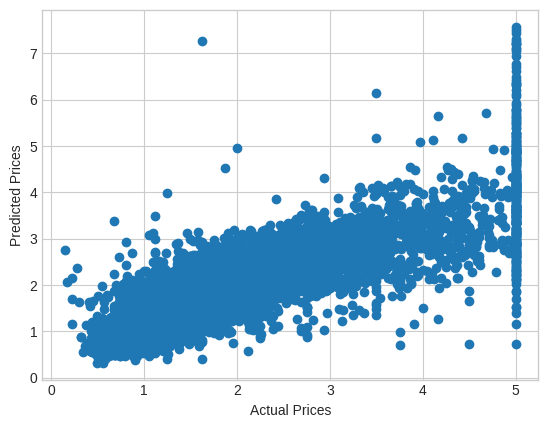

In [25]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")

plt.scatter( y_test,prediction, marker='o')

plt.show

Now just like linear models we can use regularisation to reduce the number of parameters in our model. You can use L1 and L2 regularisation in Keras and it also allows you to specify your own [regularisation function](https://keras.io/regularizers).

>>Consider running the example a few times and compare the average performance.

>> Can you find another metric that will demonstrate how we are performing?

>> In this example we were fortunate to have all continous variables. What would you do if you had categorical variables?

>> Did you notice the number of parameters in the model description. Can you explain why we have 76 weights/parameters?

Put your thoughts on the comments board.



